# setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time

from IPython.display import display

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda:0


# functions

In [3]:
class CNNModel(nn.Module):
    def __init__(self, conv_layers=None, fc_layers=None, dropout_probs=None):
        """
        `todo`
        """
        super(CNNModel, self).__init__()
        #
        if conv_layers is None:
            conv_layers = [(32, 3, 1, 1), (64, 3, 1, 1)]  # (filtros, kernel_size, stride, padding)
        if fc_layers is None:
            fc_layers = [512, 10]
        if dropout_probs is None:
            dropout_probs = [0.0] * (len(fc_layers) - 1)
        # 
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        for i, (filters, kernel_size, stride, padding) in enumerate(conv_layers):
            # convolution
            self.conv_layers.append(nn.Conv2d(in_channels, filters, kernel_size, stride, padding))
            # activation
            self.conv_layers.append(nn.ReLU())
            # pooling
            self.conv_layers.append(nn.MaxPool2d(2, 2))
            in_channels = filters
        #
        x = torch.randn(1, 3, 32, 32)  # CIFAR-10
        for layer in self.conv_layers:
            x = layer(x)
        conv_output_size = x.view(1, -1).size(1)
        # mlp
        self.fc_layers = nn.ModuleList()
        in_features = conv_output_size
        for i in range(len(fc_layers)):
            out_features = fc_layers[i]
            self.fc_layers.append(nn.Linear(in_features, out_features))
            # add relu e dropout
            if i < len(fc_layers) - 1:
                self.fc_layers.append(nn.ReLU())
                if dropout_probs[i] > 0:
                    self.fc_layers.append(nn.Dropout(dropout_probs[i]))
            in_features = out_features
    
    def forward(self, x):
        # conv
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        # mlp
        for layer in self.fc_layers:
            x = layer(x)
        return x

In [4]:
def load_data(batch_size=64, use_data_augmentation=False, validation_split=0.1):
    """
    `todo`
    """
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    #
    if use_data_augmentation:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        transform_train = transform_test
    #
    train_dataset = torchvision.datasets.CIFAR10(
        root='/home/dusoudeth/Documentos/github/ppgcc-neural-networks-homeworks/data/atividade_04',
        train=True,
        download=True,
        transform=transform_train
    )
    val_size = int(len(train_dataset) * validation_split)
    train_size = len(train_dataset) - val_size
    train_set, val_set = random_split(train_dataset, [train_size, val_size])
    #
    test_dataset = torchvision.datasets.CIFAR10(
        root='/home/dusoudeth/Documentos/github/ppgcc-neural-networks-homeworks/data/atividade_04',
        train=False, 
        download=True, 
        transform=transform_test
    )
    #
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    #
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    print(f"Tamanho do treino: {train_size} imagens")
    print(f"Tamanho da validação: {val_size} imagens")
    print(f"Tamanho do teste: {len(test_dataset)} imagens")
    return train_loader, val_loader, test_loader, classes

In [5]:
def train_model(model, train_loader, val_loader, optimizer_name='sgd', lr=0.01, momentum=0.9,
                num_epochs=10, use_early_stopping=True, patience=5):
    """
    `todo`
    """
    train_losses = list()
    val_losses = list()
    train_accs = list()
    val_accs = list()
    #
    criterion = nn.CrossEntropyLoss()
    if optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Otimizador deve ser 'sgd' ou 'adam'")
    model = model.to(device)
    #
    best_val_loss = float('inf')
    counter = 0
    #
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f"Época {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            if (i+1) % 100 == 0:
                print(f'  Lote: {i+1}/{len(train_loader)}, Perda: {running_loss/(i+1):.4f}, Acurácia: {100.*correct/total:.2f}%')
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        #
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        #
        print(f'  Treino - Perda: {train_loss:.4f}, Acurácia: {train_acc:.2f}%')
        print(f'  Validação - Perda: {val_loss:.4f}, Acurácia: {val_acc:.2f}%')
        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                print(f'Early stopping acionado na época {epoch+1}')
                model.load_state_dict(torch.load('best_model.pth'))
                break
    time_elapsed = time.time() - start_time
    print(f'Treinamento concluído em {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    return train_losses, val_losses, train_accs, val_accs

In [6]:
def evaluate_model(model, test_loader):
    """
    `todo`
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100. * correct / total
    print(f'Acurácia no conjunto de teste: {test_acc:.2f}%')
    return test_acc

In [7]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    `todo`
    """
    plt.figure(figsize=(12, 5))
    #
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Treino')
    plt.plot(val_losses, label='Validação')
    plt.title('Perda por Época')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    #
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Treino')
    plt.plot(val_accs, label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia (%)')
    plt.legend()
    #
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

100%|██████████| 170498071/170498071 [00:08<00:00, 19099099.40it/s]


Extracting /home/dusoudeth/Documentos/github/ppgcc-neural-networks-homeworks/data/atividade_04/cifar-10-python.tar.gz to /home/dusoudeth/Documentos/github/ppgcc-neural-networks-homeworks/data/atividade_04
Files already downloaded and verified
Tamanho do treino: 45000 imagens
Tamanho da validação: 5000 imagens
Tamanho do teste: 10000 imagens
CNNModel(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)
Época 1/3
  Lote: 100/704, Perda: 2.1652, Acurácia: 

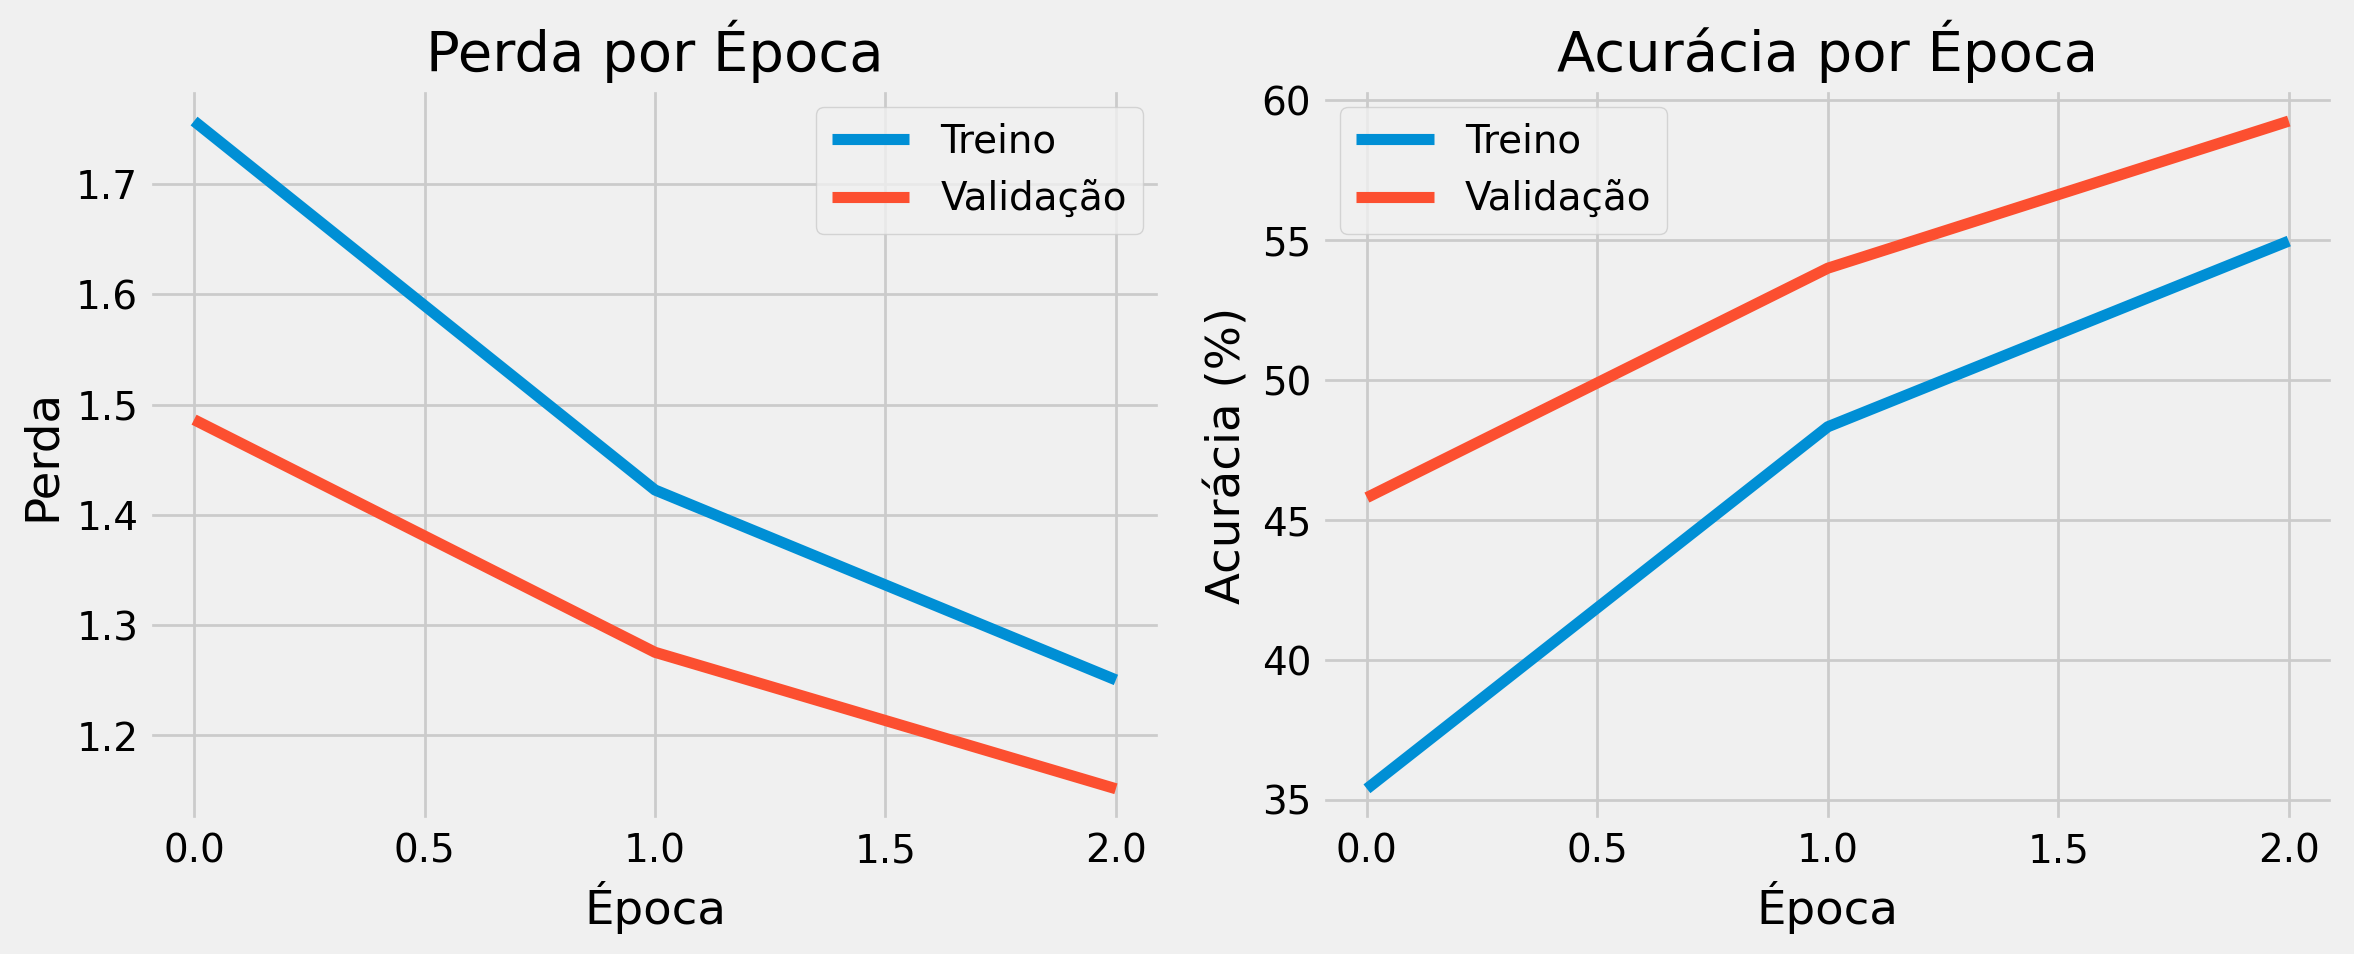

In [8]:
batch_size = 64
use_data_augmentation = True
validation_split = 0.1
conv_layers = [
    (32, 3, 1, 1),
    (64, 3, 1, 1),
]
fc_layers = [512, 10]
dropout_probs = [0.25]
#
optimizer_name = 'sgd'  # 'sgd' ou 'adam'
learning_rate = 0.01
momentum = 0.9
num_epochs = 3
use_early_stopping = True
patience = 5
#
train_loader, val_loader, test_loader, classes = load_data(
    batch_size, use_data_augmentation, validation_split
)
#
model = CNNModel(conv_layers, fc_layers, dropout_probs)
print(model)
#
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, optimizer_name, learning_rate,
    momentum, num_epochs, use_early_stopping, patience
)
test_acc = evaluate_model(model, test_loader)

plot_training_history(train_losses, val_losses, train_accs, val_accs)